# Detect AI vs. Human-Generated Images
This dataset comes from Kaggle.
https://www.kaggle.com/competitions/detect-ai-vs-human-generated-images

## Purpose
The purpose is to develop a model to distinguish between AI generated and human generated images. The dataset includes image pairs of human generated images that were captioned and AI generated images based on the captions.

## EDA
Below are pairs of example images to visualize the nature of the dataset.

In [1]:
%pip install kagglehub


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Kaggle provide the following code when you click on the Download button
# import kagglehub

# Download latest version
# path = kagglehub.dataset_download("alessandrasala79/ai-vs-human-generated-dataset")
path = "/teamspace/studios/this_studio"
print("Path to dataset files:", path)

Path to dataset files: /teamspace/studios/this_studio


In [2]:
import pandas as pd

train_df = pd.read_csv(path + "/train.csv")
test_df = pd.read_csv(path + "/test.csv")

print(train_df.head())
print(test_df.head())

# the dataframe contain labels and filenames to the images

   Unnamed: 0                                        file_name  label
0           0  train_data/a6dcb93f596a43249135678dfcfc17ea.jpg      1
1           1  train_data/041be3153810433ab146bc97d5af505c.jpg      0
2           2  train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg      1
3           3  train_data/8542fe161d9147be8e835e50c0de39cd.jpg      0
4           4  train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg      1
                                                  id
0  test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg
1  test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg
2  test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg
3  test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg
4  test_data_v2/a16495c578b7494683805484ca27cf9f.jpg


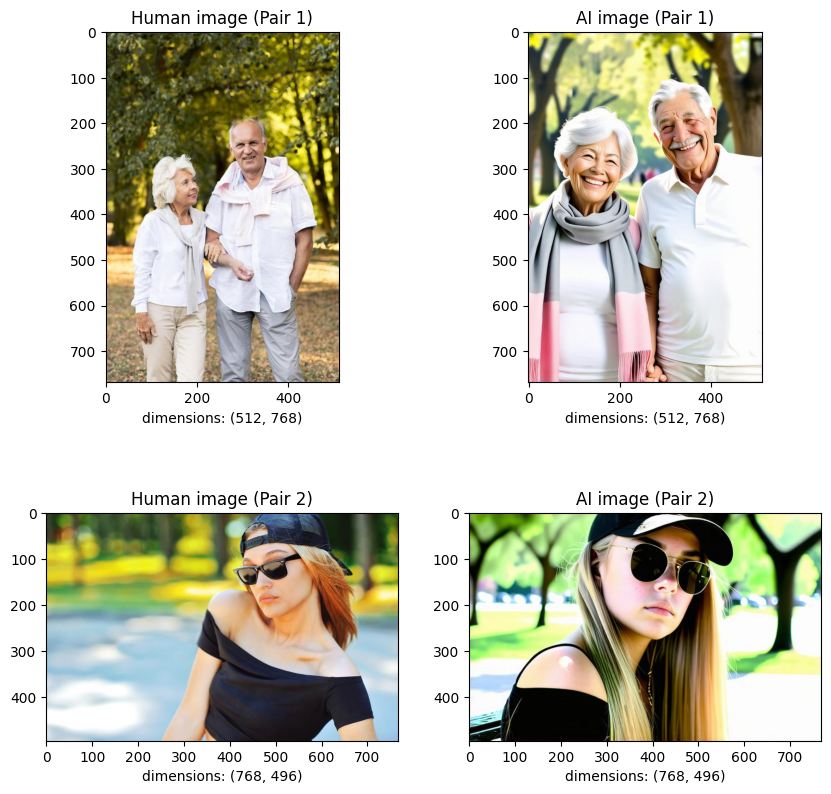

In [3]:
from PIL import Image
from matplotlib import pyplot as plt

# Load the first pair of images
human_image1 = Image.open(path + "/" + train_df[train_df["label"] == 0]["file_name"].iloc[0])
ai_image1 = Image.open(path + "/" + train_df[train_df["label"] == 1]["file_name"].iloc[0])

# Load the second pair of images
from random import randint
i = randint(1, len(train_df[train_df["label"] == 0]))
human_image2 = Image.open(path + "/" + train_df[train_df["label"] == 0]["file_name"].iloc[i])
ai_image2 = Image.open(path + "/" + train_df[train_df["label"] == 1]["file_name"].iloc[i])

# Create a figure with 2 rows and 2 columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# First row: first pair of images
axes[0, 0].imshow(human_image1)
axes[0, 0].set_title("Human image (Pair 1)")
dimensions = human_image1.size
axes[0, 0].set_xlabel(f"dimensions: {dimensions}")

axes[0, 1].imshow(ai_image1)
axes[0, 1].set_title("AI image (Pair 1)")
dimensions = ai_image1.size
axes[0, 1].set_xlabel(f"dimensions: {dimensions}")

# Second row: second pair of images
axes[1, 0].imshow(human_image2)
axes[1, 0].set_title("Human image (Pair 2)")
dimensions = human_image2.size
axes[1, 0].set_xlabel(f"dimensions: {dimensions}")

axes[1, 1].imshow(ai_image2)
axes[1, 1].set_title("AI image (Pair 2)")
dimensions = ai_image2.size
axes[1, 1].set_xlabel(f"dimensions: {dimensions}")

plt.show()


## EDA cont...
The images are in a variety of sizes and aspect ratios all with some sidelength of 768 and a second sidelength of a variety of values. Most of the images are RGB with a few black and white images.

The model will require transformations to a consistent size and aspect ratio. Also, the black and white images will be transformed to RGB images.

In [4]:
# Check all of the images and list all dimensions
dimensions = set()
modes = set()
for file_name in train_df["file_name"]:
    image = Image.open(path + "/" + file_name)
    dimensions.add(image.size)
    modes.add(image.mode)

print(dimensions)
print(modes)

{(768, 576), (480, 768), (768, 640), (416, 768), (768, 704), (656, 768), (768, 768), (592, 768), (704, 768), (528, 768), (352, 768), (640, 768), (768, 176), (768, 112), (768, 240), (768, 304), (768, 368), (768, 432), (768, 496), (768, 560), (464, 768), (768, 624), (768, 688), (768, 752), (576, 768), (752, 768), (688, 768), (512, 768), (336, 768), (768, 160), (448, 768), (400, 768), (768, 224), (768, 288), (624, 768), (768, 352), (768, 416), (768, 480), (768, 544), (768, 608), (768, 672), (736, 768), (768, 736), (560, 768), (384, 768), (496, 768), (320, 768), (768, 144), (432, 768), (768, 208), (768, 272), (768, 336), (768, 528), (768, 400), (768, 592), (768, 464), (768, 656), (768, 720), (672, 768), (608, 768), (720, 768), (544, 768), (768, 128), (368, 768), (768, 192), (768, 256), (768, 320), (768, 384), (768, 448), (768, 512)}
{'RGB', 'L'}

## EDA cont...
Both for my own model as well as a ResNet based model, normalizing on dataset statistics is a good practice. The good below generates the statistics for the dataset. I use a transform to resize to the image size I intend to use for both models (512x512).

### Statistics
Mean: [0.6238067150115967, 0.5922583341598511, 0.5293540358543396]
Std: [0.3335755169391632, 0.3218654990196228, 0.3552871346473694]

In [4]:
from ImageDataset import ImageDataset
import torch
from torchvision import transforms

# Transform: Convert to Tensor only (no normalization yet)
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

stat_dataset = ImageDataset(path, train_df, transform=transform)
loader = torch.utils.data.DataLoader(stat_dataset, batch_size=64, shuffle=False, num_workers=4)

# Compute mean and std
sum_channels = torch.zeros(3)
sum_squared_channels = torch.zeros(3)
n_samples = 0  # Track the actual number of image samples

for batch in loader:
    images = batch[0]  # Extract only images, ignore labels
    batch_samples = images.size(0)  # Actual batch size (handles smaller last batch)
    images = images.view(batch_samples, 3, -1)  # Flatten spatial dimensions

    # Accumulate sum and squared sum per channel
    sum_channels += images.sum(dim=[0, 2])  # Sum of pixel values
    sum_squared_channels += (images ** 2).sum(dim=[0, 2])  # Sum of squared pixel values
    n_samples += batch_samples  # Keep track of actual image count

# Compute mean and std per channel
mean = sum_channels / (n_samples * images.shape[2])  # Divide by total number of pixels
std = torch.sqrt((sum_squared_channels / (n_samples * images.shape[2])) - (mean ** 2))  # std = sqrt(E[X²] - (E[X])²)

print("Mean:", mean.tolist())
print("Std:", std.tolist())

Mean: [0.6238067150115967, 0.5922583341598511, 0.5293540358543396]
Std: [0.3335755169391632, 0.3218654990196228, 0.3552871346473694]


## Pytorch with Lightning
I've been learning Pytorch and Lightning as an alternative to Tensorflow and Keras. The newer libraries are more popular and Lightning provides significant utility wrapping Pytorch.

## The models
I consider two models:
1. a classical CNN approach with multiple convolution and pooling layers before a final set of fully connected layers.
2. A ResNet50 based model using a pretrained ResNet50 with a replaced final layer. The whole model was retrained on the new dataset.

In [6]:
import lightning as L
import torch
import torch.nn as nn
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# suggested by the debug output, set precission medium or high
# read more at https://lightning.ai/docs/pytorch/stable/advanced/speed.html
torch.set_float32_matmul_precision('high')

class ImageDataset(Dataset):
    def __init__(self, root_path, label_df, transform=None):
        self.images = [
            os.path.join(root_path, img_name) for img_name in label_df["file_name"]
        ]
        self.labels = label_df["label"]
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert("RGB")
        label = int(self.labels[idx])

        if self.transform:
            image = self.transform(image)

        return image, label



In [7]:

train_transforms = transforms.Compose([
    transforms.Resize(480),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.RandomCrop((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

val_transforms = transforms.Compose([
    transforms.Resize(480),
    transforms.CenterCrop((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


In [8]:
from sklearn.model_selection import train_test_split

# take only 10000 samples
# train_df = train_df.sample(10000)

train_split_df, val_split_df = train_test_split(train_df, test_size=0.2, random_state=42)

train_split_df.reset_index(drop=True, inplace=True)
val_split_df.reset_index(drop=True, inplace=True)

# print(f"Training set size: {len(train_df)}, {type(train_df)}")
# print(f"Validation set size: {len(val_df)}, {type(val_df)}")

train_dataset = ImageDataset(path, train_split_df, transform=train_transforms)
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=6, persistent_workers=True, pin_memory=True)

val_dataset = ImageDataset(path, val_split_df, transform=val_transforms)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=6, persistent_workers=True, pin_memory=True)


In [13]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

early_stop_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=0.00,
    patience=3,
    verbose=False,
    mode='min'
)

from lightning.pytorch.callbacks import ModelCheckpoint
import datetime

# YYYY-MM-DD-HH-MM
timestamp = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M")

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='./checkpoints',
    filename= timestamp + "-{epoch:02d}-{val_loss:.2f}",
    save_top_k=5,
    mode='min',
)

class CNN_Binary_Classifier(L.LightningModule):
    def __init__(self, learning_rate, train_dataloader, val_dataloader):
        super().__init__()
        # inputs are 384x384 squares
        self.conv1 = nn.Conv2d(3, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1)  # New convolutional layer
        self.conv4 = nn.Conv2d(64, 128, 3, 1)  # New convolutional layer
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 22 * 22, 128)
        self.fc2 = nn.Linear(128, 1)
        self.leaky_relu = nn.LeakyReLU()
        self.loss = nn.BCEWithLogitsLoss()
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.learning_rate = learning_rate
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.leaky_relu(self.conv1(x)))
        x = self.pool(self.leaky_relu(self.conv2(x)))
        x = self.pool(self.leaky_relu(self.conv3(x)))  # Added forward pass for new layers
        x = self.pool(self.leaky_relu(self.conv4(x)))
        x = x.view(-1, 128 * 22 * 22)
        x = self.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y.unsqueeze(1).float())
        self.log('train_loss', loss, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y.unsqueeze(1).float())
        self.log('val_loss', loss, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def train_dataloader(self):
        return self.train_dataloader

    def val_dataloader(self):
        return self.val_dataloader


model = CNN_Binary_Classifier(learning_rate=0.001, train_dataloader=train_dataloader, val_dataloader=val_dataloader)
# model = torch.compile(model)
# check out https://lightning.ai/docs/pytorch/stable/advanced/speed.html#speed-amp
# for some of these details
trainer = L.Trainer(
    accelerator="gpu", devices=4, strategy="ddp_spawn",
    precision=16,
    max_time="00:02:00:00",
    max_epochs=100,
    log_every_n_steps=1,
    callbacks=[early_stop_callback, checkpoint_callback])

Using 16bit Automatic Mixed Precision (AMP)


MisconfigurationException: `Trainer(strategy='ddp_spawn')` is not compatible with an interactive environment. Run your code as a script, or choose a notebook-compatible strategy: `Trainer(strategy='ddp_notebook')`. In case you are spawning processes yourself, make sure to include the Trainer creation inside the worker function.

In [14]:
trainer.fit(model, train_dataloader, val_dataloader)

RuntimeError: Lightning can't create new processes if CUDA is already initialized. Did you manually call `torch.cuda.*` functions, have moved the model to the device, or allocated memory on the GPU any other way? Please remove any such calls, or change the selected strategy. You will have to restart the Python kernel.

In [ ]:
model.model.save("model.pt")